# Imports

In [20]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import datetime as dt
import numpy as np

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Processing

## Selection of features

In [21]:
#Selection of existing relevant features per game : events that happened during each game
relevant_features = ['Date','HomeTeam','AwayTeam','IWH','IWD','IWA','FTR','FTHG','FTAG','HTHG','HTAG','HS','AS',
                     'HST','AST','HF','AF','HY','AY','HR','AR','HC','AC']

## Function for data processing of each season : creation of relevant features

In [22]:
def create_stat_dico(season: str, league: str) -> pd.DataFrame:
    
    """Compute statistics for a given season all the relevant statistics by going through each game
    
    Output a Dataframe of each game and each team statistics before the game
    
    Arguments : name of the season as a string, name of the league as a string
    """
    
    #stat_seasons is a 3-layer nested dico :
    # stats_season ---> dico of all clubs
    # club ---> dico of all week results
    # week ---> all stats for that week
    # stat ---> value for that specific game
     
    stats_season = {}
    file_name = '../Football_Data/Entire_Data_' + league + '.xlsx'
    xls_file = pd.ExcelFile(file_name)
    table = xls_file.parse(season)[relevant_features].dropna(axis=0)
    
    ###Features that describe team before the game
    table['week'] = 0
    
    ###For Home Team (HT)
    table['HT_average_points'] = 0.0
    table['HT_average_goal_scored_half_1'] = 0.0
    table['HT_average_goal_conceeded_half_1'] = 0.0
    table['HT_average_goal_scored_half_2'] = 0.0
    table['HT_average_goal_conceeded_half_2'] = 0.0
    table['HT_average_yellow'] = 0.0
    table['HT_average_red'] = 0.0
    table['HT_average_shots_per_goal'] = 0.0
    table['HT_on_target_precision'] = 0.0
    table['HT_average_shots_conceeded'] = 0.0
    table['HT_average_fouls_committed'] = 0.0
    table['HT_average_fouls_conceeded'] = 0.0
    
    ###For Away Team (AT)
    table['AT_average_points'] = 0.0
    table['AT_average_goal_scored_half_1'] = 0.0
    table['AT_average_goal_conceeded_half_1'] = 0.0
    table['AT_average_goal_scored_half_2'] = 0.0
    table['AT_average_goal_conceeded_half_2'] = 0.0
    table['AT_average_yellow'] = 0.0
    table['AT_average_red'] = 0.0
    table['AT_average_shots_per_goal'] = 0.0
    table['AT_on_target_precision'] = 0.0
    table['AT_average_shots_conceeded'] = 0.0
    table['AT_average_fouls_committed'] = 0.0
    table['AT_average_fouls_conceeded'] = 0.0
    
    #Number of weeks available
    nb_weeks = int(len(table)/10)
    
    if season == '2019-2020':
        nb_weeks = int(len(table)/10) - 1
    
    #Getting unique list of club names for this season
    clubs = list(set(list(table['HomeTeam'])))

    #Creation of the dictionary of stats for each club       
    for c in clubs:
        
        #First layer of dict
        stats_season[c] = {}
        
        #Selection of the games where the club is involved
        isHome = table['HomeTeam'] == c
        isAway = table['AwayTeam'] == c
        selected = table.loc[isHome | isAway]
        stats_season[c]['games_index'] = list(selected.index)
        
        
        #Initialisation of week 0 for additive params
        stats_season[c][0] = {}
        stats_season[c][0]['league_points'] = 0.0
        stats_season[c][0]['goals_scored'] = 0.0
        stats_season[c][0]['goals_scored_half'] = 0.0
        stats_season[c][0]['goals_conceeded'] = 0.0
        stats_season[c][0]['goals_conceeded_half'] = 0.0
        stats_season[c][0]['yellow'] = 0.0
        stats_season[c][0]['red'] = 0.0
        stats_season[c][0]['fouls_conceeded'] = 0.0
        stats_season[c][0]['fouls_committed'] = 0.0
        stats_season[c][0]['shots'] = 0.0
        stats_season[c][0]['shots_on_target'] = 0.0
        stats_season[c][0]['shots_conceeded'] = 0.0
        
        #Going through all the weeks of the season
        for k in range(1,len(selected)):
            
            #Second layer of dict
            stats_season[c][k] = {}
            
            #Third layer of dict
            if selected['AwayTeam'][selected.index[k-1]] == c :
                stats_season[c][k]['is_Home'] = False
            else :
                stats_season[c][k]['is_Home'] = True
            
            #Modifying the dataframe to add the statistics before game (based on previous weeks) use as features for ML
            if stats_season[c][k]['is_Home']:
                table.at[selected.index[k-1],'week'] = k
                table.at[selected.index[k-1],'HT_average_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half_2'] = (stats_season[c][k-1]['goals_scored'] - stats_season[c][k-1]['goals_scored_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half_2'] = (stats_season[c][k-1]['goals_conceeded'] - stats_season[c][k-1]['goals_conceeded_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_scored_half_1'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_goal_conceeded_half_1'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_shots_per_goal'] = sum([stats_season[c][j]['shots'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['goals_scored'] for i in range(k)]))
                table.at[selected.index[k-1],'HT_on_target_precision'] = sum([stats_season[c][j]['shots_on_target'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['shots'] for i in range(k)]))
                table.at[selected.index[k-1],'HT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'HT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
            else :
                table.at[selected.index[k-1],'AT_average_points'] = stats_season[c][k-1]['league_points'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half_2'] = (stats_season[c][k-1]['goals_scored'] - stats_season[c][k-1]['goals_scored_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half_2'] = (stats_season[c][k-1]['goals_conceeded'] - stats_season[c][k-1]['goals_conceeded_half'])/ max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_scored_half_1'] = stats_season[c][k-1]['goals_scored_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_goal_conceeded_half_1'] =  stats_season[c][k-1]['goals_conceeded_half'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_shots_per_goal'] = sum([stats_season[c][j]['shots'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['goals_scored'] for i in range(k)]))
                table.at[selected.index[k-1],'AT_on_target_precision'] = sum([stats_season[c][j]['shots_on_target'] for j in range(k)]) / max(1.0,sum([stats_season[c][i]['shots'] for i in range(k)]))
                table.at[selected.index[k-1],'AT_average_shots_conceeded']= stats_season[c][k-1]['shots_conceeded'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_yellow'] = stats_season[c][k-1]['yellow'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_red'] = stats_season[c][k-1]['red'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_committed'] = stats_season[c][k-1]['fouls_committed'] / max(k-1.0,1.0)
                table.at[selected.index[k-1],'AT_average_fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] / max(k-1.0,1.0)
                
            #Gathering the statistics of the game for the club for next games
            #League points
            if selected['FTR'][selected.index[k-1]] == "D" :
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 1.0
            elif selected['FTR'][selected.index[k-1]] == "A" and selected['AwayTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            elif selected['FTR'][selected.index[k-1]] == "H" and selected['HomeTeam'][selected.index[k-1]] == c:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points'] + 3.0
            else:
                stats_season[c][k]['league_points'] = stats_season[c][k-1]['league_points']
            
            #Goals and shots
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['HS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['HST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['AS'][selected.index[k-1]]
            else :
                stats_season[c][k]['goals_scored'] = stats_season[c][k-1]['goals_scored'] + selected['FTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_scored_half'] = stats_season[c][k-1]['goals_scored_half'] + selected['HTAG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded'] = stats_season[c][k-1]['goals_conceeded'] + selected['FTHG'][selected.index[k-1]]
                stats_season[c][k]['goals_conceeded_half'] = stats_season[c][k-1]['goals_conceeded_half'] + selected['HTHG'][selected.index[k-1]]
                stats_season[c][k]['shots'] = stats_season[c][k-1]['shots'] + selected['AS'][selected.index[k-1]]
                stats_season[c][k]['shots_on_target'] = stats_season[c][k-1]['shots_on_target'] + selected['AST'][selected.index[k-1]]
                stats_season[c][k]['shots_conceeded'] = stats_season[c][k-1]['shots_conceeded'] + selected['HS'][selected.index[k-1]]
            
            #Fouls and cards
            if stats_season[c][k]['is_Home']:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['HY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['HR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['AF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['HF'][selected.index[k-1]]
            else:
                stats_season[c][k]['yellow'] = stats_season[c][k-1]['yellow'] + selected['AY'][selected.index[k-1]]
                stats_season[c][k]['red'] = stats_season[c][k-1]['red'] + selected['AR'][selected.index[k-1]]
                stats_season[c][k]['fouls_conceeded'] = stats_season[c][k-1]['fouls_conceeded'] + selected['HF'][selected.index[k-1]]
                stats_season[c][k]['fouls_committed'] = stats_season[c][k-1]['fouls_committed'] + selected['AF'][selected.index[k-1]]
  
    return(table)

## Processing selected data

In [23]:
#List of all features created after processing
processed_features = ['week', 'HT_average_points', 'HT_average_goal_scored_half_1',
           'HT_average_goal_conceeded_half_1', 'HT_average_goal_scored_half_2',
           'HT_average_goal_conceeded_half_2', 'HT_average_yellow', 'HT_average_red',
           'HT_average_shots_per_goal', 'HT_on_target_precision',
           'HT_average_shots_conceeded', 'HT_average_fouls_committed',
           'HT_average_fouls_conceeded', 
           'AT_average_points', 'AT_average_goal_scored_half_1',
           'AT_average_goal_conceeded_half_1', 'AT_average_goal_scored_half_2',
           'AT_average_goal_conceeded_half_2', 'AT_average_yellow', 'AT_average_red',
           'AT_average_shots_per_goal', 'AT_on_target_precision',
           'AT_average_shots_conceeded', 'AT_average_fouls_committed',
           'AT_average_fouls_conceeded', 'FTR','IWH','IWD','IWA']

#Leagues selected
chosen_leagues = ['PL'] # 'Ligue1','LaLiga','SerieA','Bundesliga'

#Seasons selected
start_year = 2012
end_year = 2020

data_seasons = {}

for i in range(start_year,end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    data_seasons[season] = {}
    
    for league in chosen_leagues:
        
        print("Processing " + league + ' ' + str(i) + '-' + str(i+1))

        table = create_stat_dico(season, league)

        full_table_add = table[processed_features]
 
        data_seasons[season][league] = full_table_add


Processing PL 2012-2013


ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

## Visualize data final format

In [5]:
#Visualize the format of dataframe
full_table_add

NameError: name 'full_table_add' is not defined

# Defining train and test datasets

## Training dataset

In [6]:
#Selection of seasons used to train
train_start_year = 2012
train_end_year = 2017

train_chosen_leagues = ['PL'] #'Ligue1','LaLiga','SerieA','Bundesliga'

train_df = pd.DataFrame(columns = processed_features)

for i in range(train_start_year,train_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in train_chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [train_df, table]
        
        train_df = pd.concat(two_concat)
       

#Starting week of training
start_week_train = 20
valid = train_df['week'] > start_week_train
train_df = train_df[valid]
        
print("The model will train on : " + str(train_chosen_leagues))
        
print("The model will train on " + str(len(train_df)) + " matches from " + str(train_start_year) + '-' + str(train_start_year+1) + " to " + str(train_end_year-1) + '-' + str(train_end_year) + " !")

#Choice of the features
features = ['HT_average_goal_scored_half_1',
           'HT_average_goal_conceeded_half_1', 'HT_average_goal_scored_half_2',
           'HT_average_goal_conceeded_half_2',
           'HT_average_shots_per_goal', 'HT_on_target_precision',
           'HT_average_shots_conceeded',
           'AT_average_goal_scored_half_1',
           'AT_average_goal_conceeded_half_1', 'AT_average_goal_scored_half_2',
           'AT_average_goal_conceeded_half_2',
           'AT_average_shots_per_goal', 'AT_on_target_precision',
           'AT_average_shots_conceeded']

n_features = len(features)

train_x = train_df[features]

train_y = train_df['FTR']


KeyError: 'PL'

## Testing dataset

In [7]:
#Selection of seasons used to test
test_start_year = train_end_year
test_end_year = 2020

test_df = pd.DataFrame(columns = processed_features)

test_chosen_leagues = ['PL'] # 'Ligue1','LaLiga','SerieA','Bundesliga'

for i in range(test_start_year, test_end_year):
    
    season = str(i) + '-' + str(i + 1)
    
    for league in test_chosen_leagues:
        
        table = data_seasons[season][league]
        
        two_concat = [test_df, table]
        
        test_df = pd.concat(two_concat)

#Starting week of training
start_week_test = 20
valid = test_df['week'] > start_week_test
test_df = test_df[valid]

#Choice of the features (we first delete the odds)
test_x = test_df[features]

#Labels for training
test_y = test_df['FTR']


print("The model will test on : " + str(test_chosen_leagues))
      
print("The model will test on " + str(len(test_df)) + " matches from " + str(test_start_year) + '-' + str(test_start_year+1) + " to " + str(test_end_year-1) + '-' + str(test_end_year) + " !")



KeyError: '2017-2018'

# Let's apply classical ML algorithms

## Importing models

In [8]:
#Dealing with format and metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

#Classical classifiers
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemblist models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Neural Networks
from sklearn.neural_network import MLPClassifier

## Training and testing : getting probabilities for test data

### GridSearch on Random Forest

In [9]:
parameters = {'n_estimators':[100,200], 'max_depth':[25,100], 'min_samples_split':[5,10]}

forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, max_features='auto', 
                                max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                min_impurity_split=None, bootstrap=True, oob_score=False, 
                                n_jobs=None, random_state=None)

RFClassifier = GridSearchCV(forest, parameters,verbose=100)

name = 'RF'

print("Training " + name + " ...")
RFClassifier.fit(train_x, train_y)

y_pred = RFClassifier.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
#Calculate probabilities:
probas = RFClassifier.predict_proba(test_x)
;

Training RF ...


NameError: name 'train_x' is not defined

### Testing various models

In [10]:
# Dealing with parameters
C = 0.8

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga', tol=0.000001,
                                      multi_class='multinomial',
                                      max_iter=1000000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga', tol=0.000001,
                                                    multi_class='multinomial',
                                                    max_iter=1000000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Random Forest': RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=25, 
                                            min_samples_split=2, min_samples_leaf=1, 
                                            min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                            min_impurity_split=None, bootstrap=True, oob_score=False, 
                                            n_jobs=None, random_state=None)
}

n_classifiers = len(classifiers)

results = {}

for index, (name, classifier) in enumerate(classifiers.items()):
    print("Training " + name + "...")
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    print("Accuracy (test) for %s: %0.1f%% " % (name, accuracy * 100))
    
    #Calculate probabilities:
    probas = classifier.predict_proba(test_x)
    
    #store them in a dict
    results[name] = probas
;

Training L1 logistic...


NameError: name 'train_x' is not defined

# Let's try with Neural Networks

## Imports

In [11]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

#Keras tuners
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

#Time
import time

Instructions for updating:
non-resource variables are not supported in the long term


## Parameters

In [12]:
n_classes = 3
n_features = train_x.shape[1]
n_epochs = 10

NameError: name 'train_x' is not defined

## Preprocessing

In [13]:
test_X = test_x.values
test_Y = test_y.values
train_X = train_x.values
train_Y = train_y.values

#Features
min_max_scaler = preprocessing.MinMaxScaler()
train_X_scaled = min_max_scaler.fit_transform(train_X)
test_X_scaled = min_max_scaler.transform(test_X)

#Labels
# integer encode
label_encoder = LabelEncoder()
train_Y_integer_encoded = label_encoder.fit_transform(train_Y)
test_Y_integer_encoded = label_encoder.transform(test_Y)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
train_Y_integer_encoded = train_Y_integer_encoded.reshape(len(train_Y_integer_encoded), 1)
train_Y_onehot_encoded = onehot_encoder.fit_transform(train_Y_integer_encoded)
test_Y_integer_encoded = test_Y_integer_encoded.reshape(len(test_Y_integer_encoded), 1)
test_Y_onehot_encoded = onehot_encoder.transform(test_Y_integer_encoded)


NameError: name 'test_x' is not defined

## Searching for a relevant architecture model

In [14]:
log_dir = f"{int(time.time())}"

def build_model(hp):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
    
    for i in range(hp.Int("n_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Int(f"layer_{i}_neurons",min_value = 10, max_value = 200, step = 20), activation =tf.nn.relu))

    #Output layer
    model.add(tf.keras.layers.Dense(n_classes,activation =tf.nn.softmax))

    #Compile
    model.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ["accuracy"])
    return model


In [15]:
tuner = RandomSearch(
        build_model,
        objective = "val_acc",
        max_trials = 10,
        executions_per_trial = 2,
        directory = log_dir
        )

tuner.search(x = train_X_scaled,
             y = train_Y_onehot_encoded,
             epochs = 10,
             batch_size = 25,
             validation_data = (test_X_scaled, test_Y_onehot_encoded))

;

Traceback (most recent call last):
  File "/home/xcoder/.local/lib/python3.6/site-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-14-516ad22e8656>", line 6, in build_model
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
NameError: name 'n_features' is not defined
Traceback (most recent call last):
  File "/home/xcoder/.local/lib/python3.6/site-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-14-516ad22e8656>", line 6, in build_model
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
NameError: name 'n_features' is not defined
Traceback (most recent call last):
  File "/home/xcoder/.local/lib/python3.6/site-packages/keras_tuner/engine/

Invalid model 0/5
Invalid model 1/5
Invalid model 2/5
Invalid model 3/5
Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/home/xcoder/.local/lib/python3.6/site-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-14-516ad22e8656>", line 6, in build_model
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
NameError: name 'n_features' is not defined
Traceback (most recent call last):
  File "/home/xcoder/.local/lib/python3.6/site-packages/keras_tuner/engine/hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-14-516ad22e8656>", line 6, in build_model
    model.add(tf.keras.layers.Dense(hp.Int("n_input_neurons",min_value = 10, max_value = 200, step = 20), input_dim=n_features, activation =tf.nn.relu))
NameError: name 'n_features' is not defined
Traceback (most recent call last):
  File "/home/xcoder/.local/lib/python3.6/site-packages/keras_tuner/engine/

RuntimeError: Too many failed attempts to build model.

In [16]:
print("The best hyperparemeters found are : ")
print(tuner.get_best_hyperparameters()[0].values)
print("The summary for the best model : ")
print(tuner.get_best_models()[0].summary())

The best hyperparemeters found are : 


NameError: name 'tuner' is not defined

## Choosing final model

In [17]:
final_model = tuner.get_best_models()[0]
    
#Fit
final_model.fit(train_X_scaled, train_Y_onehot_encoded,
          batch_size=20,
          epochs=100,
          validation_data=(test_X_scaled, test_Y_onehot_encoded))

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results_ = final_model.evaluate(test_X_scaled, test_Y_onehot_encoded, batch_size=128)
print('test loss, test acc:', results_)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = final_model.predict(test_X_scaled[:3])
print('predictions shape:', predictions.shape)

;

NameError: name 'tuner' is not defined

# Function to optimize

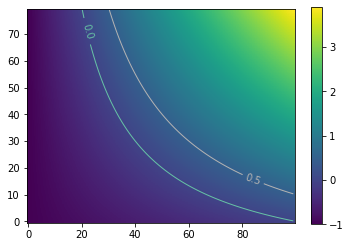

In [18]:
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
    return (x*y - 1)
 
prob = arange(0.0,1.0,0.01)
odd = arange(1.0,5.0,0.05)
X,Y = meshgrid(prob, odd) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,origin = 'lower') # drawing the function

# adding the Contour lines with labels
cset = contour(Z,[0.0, 0.5],linewidths=1,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)

colorbar(im) # adding the colobar on the right

show()

# Performance analysis

## Calculations of expected gain for each result

In [19]:
performance_df = test_df[['FTR','IWA','IWD','IWH']]
performance_df['P(A)']= pd.DataFrame(data = results['Random Forest'][:,0], columns = ['P(A)'])
performance_df['E(A)']= performance_df['P(A)'] * performance_df['IWA'] - 1.0
performance_df['P(D)']= pd.DataFrame(data = results['Random Forest'][:,1], columns = ['P(D)'])
performance_df['E(D)']= performance_df['P(D)'] * performance_df['IWD'] - 1.0
performance_df['P(H)']= pd.DataFrame(data = results['Random Forest'][:,2], columns = ['P(H)'])
performance_df['E(H)']= performance_df['P(H)'] * performance_df['IWH'] - 1.0
performance_df

KeyError: 'Random Forest'

## Selection of results to bet on and their actual performances

In [45]:
#Floor and cap on expected gain to consider
floor = 1.0
cap = 15.0

### Draws performance

In [46]:
#Selection of the draws
draw_floor = performance_df['E(D)'] > floor
draw_cap = performance_df['E(D)'] < cap
selected_draw = performance_df[draw_floor & draw_cap]

#Computation of actual gains on draws
selected_draw['Gain'] = 0.0
is_Draw = selected_draw['FTR'] == 'D'
not_Draw = selected_draw['FTR'] != 'D'
selected_draw.loc[not_Draw, 'Gain'] = -1.0
selected_draw.loc[is_Draw, 'Gain'] = selected_draw.loc[is_Draw,'IWD'] - 1.0
selected_draw['Gain'].sum()

5.5

### Aways performance

In [47]:
#Selection of the aways
away_floor = performance_df['E(A)'] > floor
away_cap = performance_df['E(A)'] < cap
selected_away = performance_df[away_floor & away_cap]

#Computation of actual gains on aways
selected_away['Gain'] = 0.0
is_Away = selected_away['FTR'] == 'A'
not_Away = selected_away['FTR'] != 'A'
selected_away.loc[not_Away, 'Gain'] = -1.0
selected_away.loc[is_Away, 'Gain'] = selected_away.loc[is_Away,'IWA'] - 1.0
selected_away['Gain'].sum()

-43.050000000000004

### Homes performance

In [48]:
#Selection of the homes
home_floor = performance_df['E(H)'] > floor
home_cap = performance_df['E(H)'] < cap
selected_home = performance_df[home_floor & home_cap]

#Computation of actual gains on aways
selected_home['Gain'] = 0.0
is_Home = selected_home['FTR'] == 'H'
not_Home = selected_home['FTR'] != 'H'
selected_home.loc[not_Home, 'Gain'] = -1.0
selected_home.loc[is_Home, 'Gain'] = selected_home.loc[is_Home,'IWH'] - 1.0
selected_home['Gain'].sum()

9.6

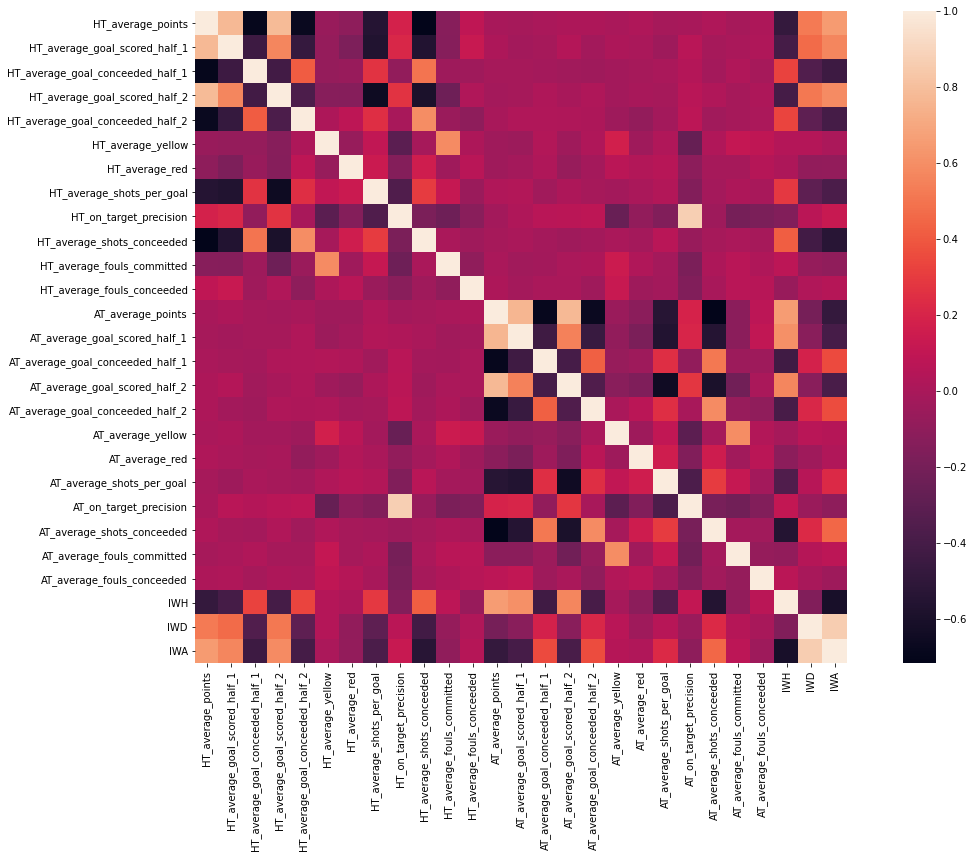

In [49]:
import matplotlib.pyplot as plt
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax)